In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv("/Users/tahafaisal/Desktop/ml-news-classification/data/data5cleaned.csv")

class_counts = data['gold_label'].value_counts()
print(class_counts)
data.head()

gold_label
Sports                492
Entertainment         491
International         486
Business              380
Science-Technology    336
Name: count, dtype: int64


,id,title,link,content,gold_label
0,0,ادارہ 'علم دوست' کی جانب سے'معلوماتِ عامہ' کے ...,https://www.express.pk/story/2733338/idara-ilm...,ادارہ 'علم دوست' کی جانب سے'معلوماتِ عامہ' کے ...,Entertainment
1,1,فلم ساز ودھو ونود چوپڑا کی نئی فلم ’زیرو سے ری...,https://www.express.pk/story/2733336/director-...,معروف فلم ساز ودھو ونود چوپڑا نے اپنی نئی فلم ...,Entertainment
2,2,عمر بڑھنے کے ساتھ وزن کم کرنا مشکل ہوتا ہے، اب...,https://www.express.pk/story/2733331/umer-barh...,ابھیشیک بچن نے اپنی نئی فلم ’آئی وانٹ ٹو ٹاک‘ ...,Entertainment
3,3,ملائکہ اروڑا والد کے انتقال کے بعد کام پر واپس...,https://www.express.pk/story/2733327/malaikaar...,مشہور اداکارہ ملائکہ اروڑا حال ہی میں والد کے ...,Entertainment
4,4,ڈائریکٹر دھرمیش درشن کا دو بار شاہ رخ خان کی ف...,https://www.express.pk/story/2733325/directord...,بالی ووڈ کے معروف ہدایتکار دھرمیش درشن نے حالی...,Entertainment


In [3]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())
    return stopwords

custom_stopwords = load_stopwords("/Users/tahafaisal/Desktop/ml-news-classification/data/stopwords.txt")


def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text)
    return [token.strip() for token in tokens]

def remove_stopwords(tokens, stopwords):
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return filtered_tokens


def normalize(text):
    return re.sub(r"[ﺍأإآا]", "ا", text)

data['content'] = data['content'].apply(
    lambda x: " ".join(remove_stopwords(tokenize(normalize(str(x))), custom_stopwords))
)

label_mapping = {label: idx for idx, label in enumerate(data['gold_label'].unique())}
data['gold_labels_encoded'] = data['gold_label'].map(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(data['content'], data['gold_labels_encoded'], test_size=0.2, random_state=80)


In [4]:
X_train.head()
y_train.head()

703     0
2058    3
193     1
22      0
629     4
Name: gold_labels_encoded, dtype: int64

In [5]:
def BagofWords(texts, max_features=5000):
    word_counts = Counter(word for text in texts for word in text.split())
    return {word: idx for idx, (word, _) in enumerate(word_counts.most_common(max_features))}

def text_to_vector(texts, vocab):
    vectors = np.zeros((len(texts), len(vocab)))
    for i, text in enumerate(texts):
        for word in text.split():
            if word in vocab:
                vectors[i, vocab[word]] += 1
    return vectors


vocab = BagofWords(X_train, max_features=5000)
X_train_vectorized = text_to_vector(X_train, vocab)
X_test_vectorized = text_to_vector(X_test, vocab)


In [6]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, alpha=0.01, dropout_rate=0.2):
        self.alpha = alpha
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.dropout_rate = dropout_rate

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return z > 0

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def dropout(self, A):
        mask = (np.random.rand(*A.shape) > self.dropout_rate)
        return A * mask

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.A1 = self.dropout(self.A1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def backward(self, X, y, output):
        m = X.shape[0]
        y_onehot = np.zeros_like(output)
        y_onehot[np.arange(m), y] = 1
        dZ2 = output - y_onehot
        dW2 = np.dot(self.A1.T, dZ2)/m
        db2 = np.sum(dZ2, axis=0, keepdims=True)/m

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1)/m
        db1 = np.sum(dZ1, axis=0, keepdims=True)/m

        self.W1 -= self.alpha * (dW1 + 0.02 * self.W1)
        self.W2 -= self.alpha * (dW2 + 0.02 * self.W2)
        self.b2 -= self.alpha * db2
        self.b1 -= self.alpha * db1

    def fit(self, X, y, epochs=1000):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, output)
            if epoch % 100 == 0:
                loss = -np.mean(np.log(output[np.arange(X.shape[0]), y]))
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

In [7]:
nn = NeuralNetwork(input_size=len(vocab), hidden_size=200, output_size=len(label_mapping), alpha=0.1)
nn.fit(X_train_vectorized, y_train.values, epochs=1000)

Epoch 0, Loss: 1.6097
Epoch 100, Loss: 0.1695
Epoch 200, Loss: 0.0953
Epoch 300, Loss: 0.0804
Epoch 400, Loss: 0.0669
Epoch 500, Loss: 0.0625
Epoch 600, Loss: 0.0624
Epoch 700, Loss: 0.0630
Epoch 800, Loss: 0.0563
Epoch 900, Loss: 0.0605


In [8]:
y_pred = nn.predict(X_test_vectorized)
accuracy = np.mean(y_pred == y_test.values)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.80%


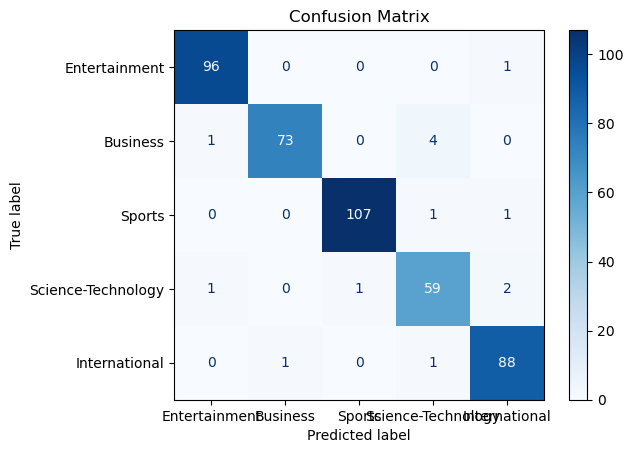

In [9]:
y_true = y_test.values
conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_mapping.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()